In [59]:
# import libraries

import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.utils.vis_utils import plot_model

In [60]:
# run the data_processing file to get the training and validation sets

%run ../data_processing.ipynb

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16626 entries, 0 to 16625
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Administrative  16626 non-null  int64  
 1   Informational   16626 non-null  int64  
 2   ProductRelated  16626 non-null  int64  
 3   ExitRates       16626 non-null  float64
 4   PageValues      16626 non-null  float64
 5   SpecialDay      16626 non-null  float64
 6   Month           16626 non-null  int64  
 7   Region          16626 non-null  int64  
 8   TrafficType     16626 non-null  int64  
 9   VisitorType0    16626 non-null  float64
 10  VisitorType1    16626 non-null  float64
 11  Weekend         16626 non-null  int64  
 12  Revenue         16626 non-null  int64  
dtypes: float64(5), int64(8)
memory usage: 1.6 MB


In [61]:
# compile parameters (can be updated for different variations and test)
X_TRAIN = x_train
Y_TRAIN = y_train

X_VALID = x_valid
Y_VALID = y_valid

VALIDATION = (x_valid, y_valid)

ACTIVATION_FUNCTION = 'relu'
ACTIVATION_FUNCTION_OUTPUT = 'softmax'
BATCH_SIZE = 32
EPOCHS = 50
INPUT_DIM = 12
KERNEL_INITIALIZER = 'he_uniform'
LEARNING_RATE = 0.03
LOSS_FUNCTION = 'categorical_crossentropy'
METRICS = ['accuracy']
OPTIMIZER = tf.optimizers.Adam(learning_rate=LEARNING_RATE)
VERBOSE = 0

# list of architectures to test (can be updated to test different architectures)
architectures = ['128-2', '256-2', '256-128-2', '128-256-128-2', '512-256-128-96-2']

# dataframe to hold the loss and accuracy for each architecture
df_result = pd.DataFrame(columns=['architecture', 'training_loss',
                                  'training_accuracy', 'validation_loss',
                                  'validation_accuracy'])

# clears the dataset to avoid redundancy
df_result = df_result.iloc[0:0]

In [62]:
# create a baseline classifier
def create_baseline(arch):

    # init a sequential NN
    classifier = Sequential()

    # Define the model architecture
    
    # 1st layer - takes in input
    classifier.add(Dense(units=arch[0], kernel_initializer=KERNEL_INITIALIZER,
                         activation=ACTIVATION_FUNCTION, input_dim=INPUT_DIM))
    
    # dynamic hidden layers based on architecture
    if len(arch) > 2:
        for layer in range(1,len(arch)-1):
            classifier.add(Dense(units=arch[layer],
                                 kernel_initializer=KERNEL_INITIALIZER,
                                 activation=ACTIVATION_FUNCTION))

    # output layer
    classifier.add(Dense(units=arch[-1], kernel_initializer=KERNEL_INITIALIZER,
                         activation=ACTIVATION_FUNCTION_OUTPUT))

    return classifier

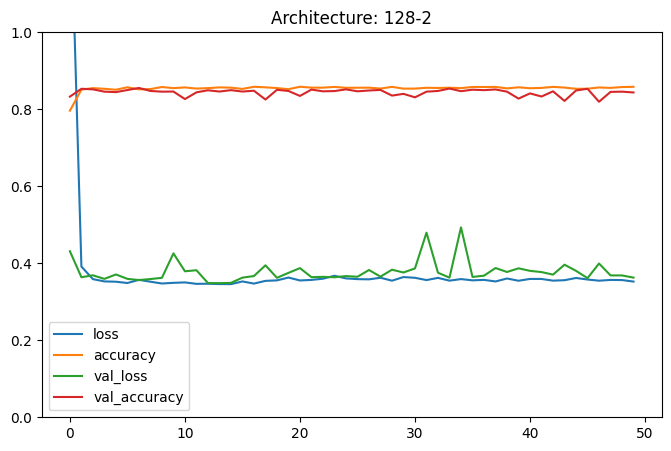

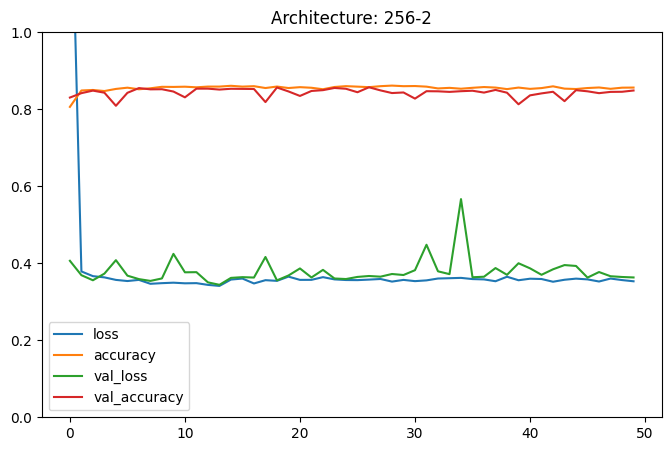

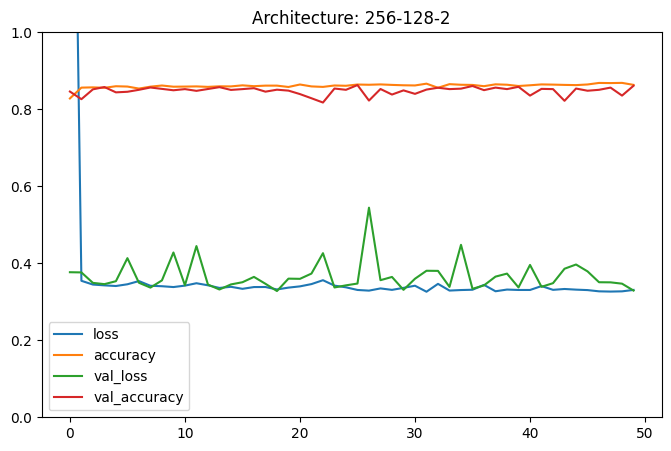

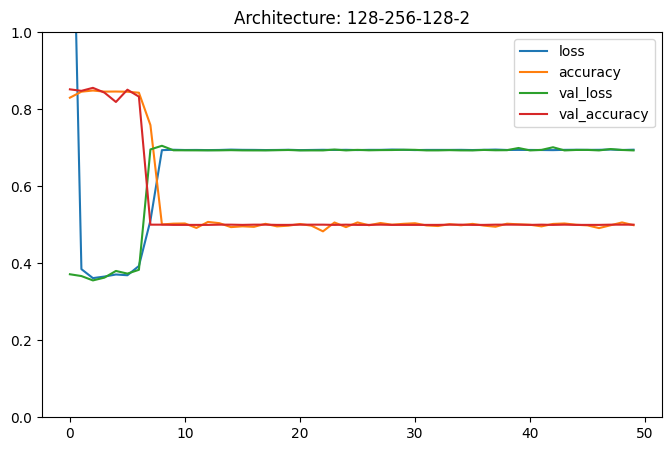

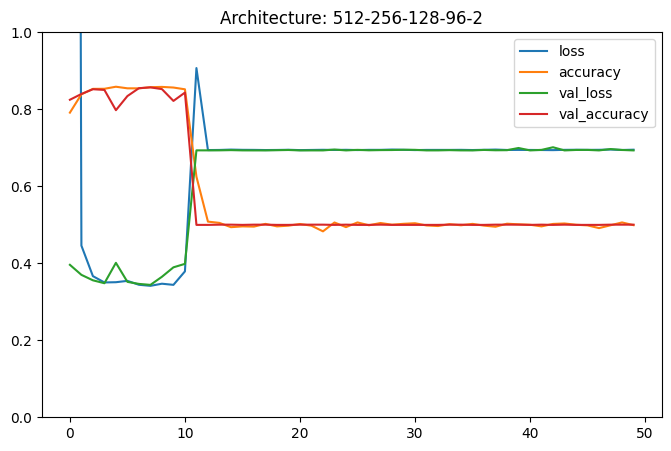

In [63]:
# loop through the architectures list to test all the architectures
for ARCHITECTURE in architectures:
    
    arch = ARCHITECTURE.split('-')

    # create a baseline model
    model = create_baseline(arch)
    plot_model(model, to_file='figures/model_' + ARCHITECTURE + '_plot.png', show_shapes=True, show_layer_names=True)

    # compile the model with values defined above
    model.compile(optimizer=OPTIMIZER,
                  loss=LOSS_FUNCTION, metrics=METRICS)
    
    # train the model
    history = model.fit(X_TRAIN, Y_TRAIN, validation_data=VALIDATION,
                            epochs=EPOCHS, batch_size=BATCH_SIZE,
                            verbose=VERBOSE)

    # plot
    pd.DataFrame(history.history).plot(figsize=(8,5))
    plt.grid = True
    plt.ylim(0, 1)
    plt.title('Architecture: ' + str(ARCHITECTURE))
    plt.savefig('figures/architecture_'+str(ARCHITECTURE)+'.png')
    plt.show()

    # evaluation - loss and accuracy
    model_train_loss, model_train_accuracy = model.evaluate(X_TRAIN, Y_TRAIN,
                                                            verbose=VERBOSE)
    model_valid_loss, model_valid_accuracy = model.evaluate(X_VALID, Y_VALID,
                                                            verbose=VERBOSE)

    # add the evaluation results to the dataset
    df_result = pd.concat([pd.DataFrame([[ARCHITECTURE, model_train_loss,
                                         model_train_accuracy,
                                         model_valid_loss,
                                         model_valid_accuracy]],
                                         columns=df_result.columns),
                                         df_result],
                                         ignore_index=True)

In [64]:
# display the evaluation results dataframe

df_result

,architecture,training_loss,training_accuracy,validation_loss,validation_accuracy
0,512-256-128-96-2,0.693169,0.499925,0.693163,0.500301
1,128-256-128-2,0.693169,0.499925,0.693163,0.500301
2,256-128-2,0.312081,0.874286,0.329120,0.861094
3,256-2,0.352443,0.859925,0.363179,0.848767
4,128-2,0.350197,0.856842,0.362760,0.843656


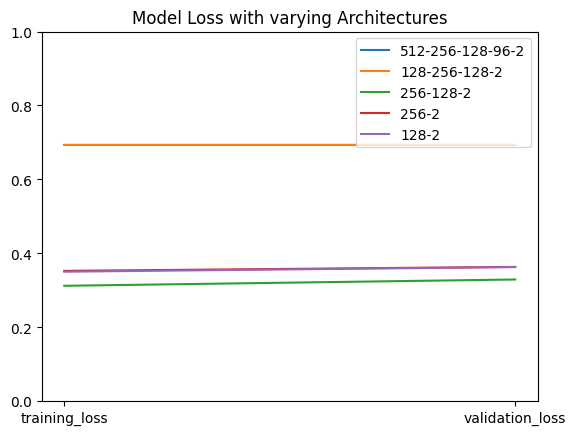

In [65]:
# visualize loss for training and validation sets

# x values
x = ['training_loss', 'validation_loss']

# training and validation loss for each architecture
for _idx in range(df_result.shape[0]):
    plt.plot(x, [df_result.iloc[_idx]['training_loss'],
                 df_result.iloc[_idx]['validation_loss']],
                 label=str(df_result.iloc[_idx]['architecture']))

# plot
plt.grid = True
plt.ylim(0, 1)
plt.title('Model Loss with varying Architectures')
plt.legend(loc='upper right')
plt.savefig('figures/loss.png')
plt.show()

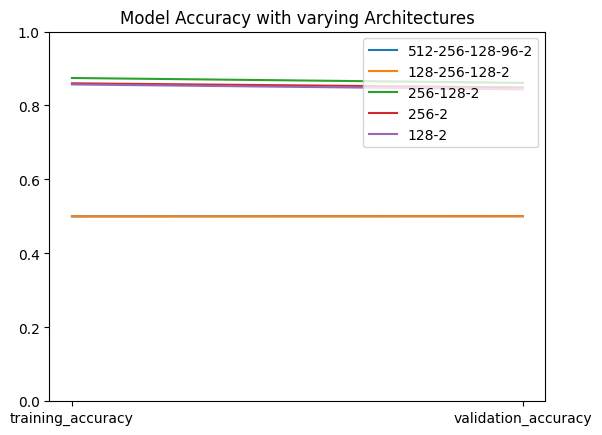

In [66]:
# visualize accuracy for training and validation sets

# x values
x = ['training_accuracy', 'validation_accuracy']

# training and validation accuracy for each architecture
for _idx in range(df_result.shape[0]):
    plt.plot(x, [df_result.iloc[_idx]['training_accuracy'],
                 df_result.iloc[_idx]['validation_accuracy']],
                 label=str(df_result.iloc[_idx]['architecture']))

# plot
plt.grid = True
plt.ylim(0, 1)
plt.title('Model Accuracy with varying Architectures')
plt.legend(loc='upper right')
plt.savefig('figures/accuracy.png')
plt.show()